In [1]:
import ctypes
from ctypes import c_char_p
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lib = ctypes.CDLL("modele/linear/target/debug/liblinear_classification.so")

# Configurer la fonction
image_to_vector = lib.image_to_vector
image_to_vector.argtypes = [ctypes.c_char_p]
image_to_vector.restype = ctypes.POINTER(ctypes.c_ubyte * (200*200))

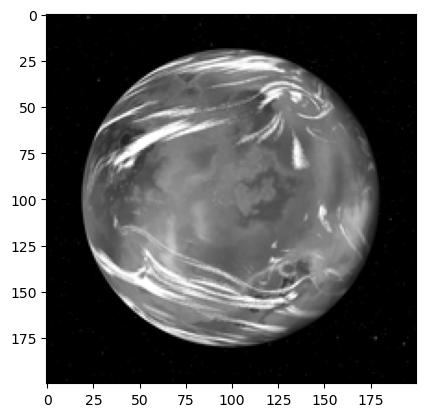

In [3]:
# path_to_image = b"data/dataset/resized/gas_giant/HD-207832-c.png"
path_to_image = b"data/dataset/resized/super_earth/HD-85512-b.png"
path_to_imagee = b"data/dataset/resized/neptune-like/HD-13808-b.png"

# call de la fonction Rust
raw_data = image_to_vector(path_to_image).contents
raw_dataa = image_to_vector(path_to_imagee).contents

# Convertir en array numpy
image_array = np.array(raw_data, dtype=np.uint8).reshape((200, 200))

# Visualiser l'image
plt.imshow(image_array, cmap='gray')
plt.show()

In [4]:
categories = {'gas_giant': 0, 'neptune-like': 1, 'super_earth': 2}
features = []
labels = []

dataset_path = 'data/dataset/resized'

for category, label in categories.items():
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        if image_path.endswith(('.png', '.jpg', '.jpeg')):
            image_path = c_char_p(image_path.encode('utf-8'))
            vector = image_to_vector(image_path).contents
            vector_array = np.array(vector, dtype=np.uint8).reshape((200, 200))
            features.append(vector_array)
            labels.append(label)


features = np.array(features)
labels = np.array(labels)

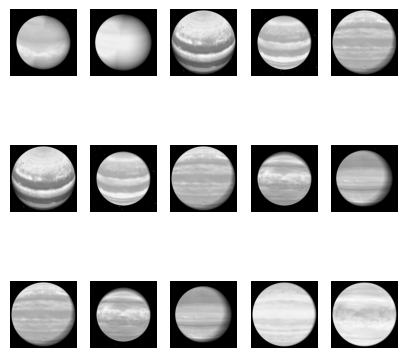

In [6]:

fig, axs = plt.subplots(3, 5, figsize=(5, 5))

for i in range(3):
    for j in range(5):
        img_index = i * 2 + j
        ax = axs[i, j]
        ax.imshow(features[img_index], cmap='gray')
        ax.axis('off')

plt.show()